This code snippet executes and analyses the shrinkage of target word sets from all stimuli datasets.

In [22]:
import json
import os
import random

random.seed(1111)

from transformers import BertTokenizer

In [23]:
# import original stimuli datasets

TEST_EXT = '.jsonl'
all_tests = sorted([entry[:-len(TEST_EXT)]
                        for entry in os.listdir()
                        if not entry.startswith('.') and entry.endswith('word' + TEST_EXT)])

tests_original = {bias_test: {'targ1': None, 'targ2': None, 'attr1': None, 'attr2': None} for bias_test in all_tests}
tests_reduced = {bias_test: {'targ1': {}, 'targ2': {}, 'attr1': {}, 'attr2': {}} for bias_test in all_tests}

for test in all_tests:
    file = json.load(open(test+TEST_EXT, 'r'))
    tests_original[test]['targ1'] = file['targ1']['singular']
    tests_original[test]['targ2'] = file['targ2']['singular']
    tests_original[test]['attr1'] = file['attr1']
    tests_original[test]['attr2'] = file['attr2']

In [24]:
# load BERT (bbu) tokenizer from local files
tokenizer = BertTokenizer.from_pretrained('../models/bert/base-uncased/')

In [25]:
def filter_stimuli(stimuli_lst, tokenizer):
    """ Function to reduce word list """
    return [w.strip().lower() for w in stimuli_lst if w.strip().lower() in tokenizer.vocab]

for test in all_tests:
    # reduce original target word sets
    tests_reduced[test]['targ1']['singular'] = filter_stimuli(tests_original[test]['targ1'], tokenizer)
    tests_reduced[test]['targ2']['singular'] = filter_stimuli(tests_original[test]['targ2'], tokenizer)
    # save respective attribute word sets
    tests_reduced[test]['attr1'] = tests_original[test]['attr1']
    tests_reduced[test]['attr2'] = tests_original[test]['attr2']
    
    # target word sets have to be of equal size
    if len(tests_reduced[test]['targ1']['singular']) != len(tests_reduced[test]['targ2']['singular']):
        min_n = min([len(tests_reduced[test]['targ1']['singular']), len(tests_reduced[test]['targ2']['singular'])])
        # randomly sample min number of stimuli for both word sets
        if not len(tests_reduced[test]['targ1']['singular']) == min_n:
            tests_reduced[test]['targ1']['singular'] = random.sample(tests_reduced[test]['targ1']['singular'], min_n)
        else:
            tests_reduced[test]['targ2']['singular'] = random.sample(tests_reduced[test]['targ2']['singular'], min_n)


In [5]:
print(tests_reduced['C1_name_word']['targ1'])

{'singular': ['clover', 'poppy', 'iris', 'orchid', 'rose', 'daisy', 'lily', 'violet', 'magnolia']}


In [9]:
# save word sets
for test in all_tests:
    # only save test if target word sets are not empty
    if len(tests_reduced[test]['targ1']['singular']) > 0:
        with open('LPBS/reduced/'+test+'.jsonl', 'w') as file:
            json.dump(tests_reduced[test], file,  indent=4)

Despite datasets containing stimuli which consist of multiple words, e.g. `C3_term_word`, there are no target stimuli left after shrinking for the bias tests `I1_name_word` and `I2_name_word`. Further, `C9_name_m_word` does not differ with respect to the target words from `C9_name_word` and thus the following analysis is conducted for the remaining bias tests:
- C1_name
- C3_name
- C6_name
- C6_term
- C9_name
- C9_term
- Occ_name
- Occ_term

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
tests = ['C1_name_word', 'C3_name_word', 'C6_name_word', 'C9_name_word', 'Occ_name_word', 'C6_term_word', 'C9_term_word', 'Occ_term_word']
data = {'prop': [(len(tests_reduced[test]['targ1']['singular']) / len(tests_original[test]['targ1']))*100 for test in tests]}
df = pd.DataFrame(data,columns=['prop'], index = tests)
print(df)

                     prop
C1_name_word    36.000000
C3_name_word    31.250000
C6_name_word   100.000000
C9_name_word    42.857143
Occ_name_word   57.692308
C6_term_word   100.000000
C9_term_word    66.666667
Occ_term_word  100.000000


In [30]:
tests_small = ['C1_name_word', 'C3_name_word', 'C6_name_word', 'Occ_name_word', 'C9_term_word']
data = {'proportion in %': [(len(tests_reduced[test]['targ1']['singular']) / len(tests_original[test]['targ1']))*100 for test in tests_small]}
df = pd.DataFrame(data,columns=['proportion in %'], index = ['C1','C3','C6','Occ','C9'])
print(df)

     proportion in %
C1         36.000000
C3         31.250000
C6        100.000000
Occ        57.692308
C9         66.666667


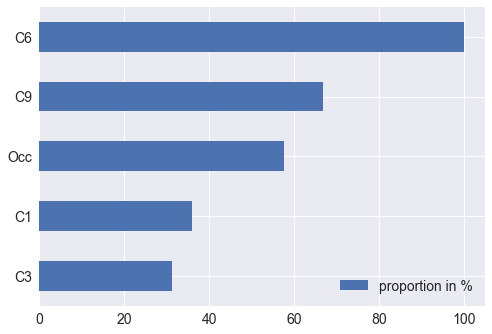

In [39]:
plt.style.use('seaborn')
df.sort_values(by='proportion in %').plot.barh()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(prop={'size': 14})
#plt.ylabel('Bias test')
#plt.xlabel('Proportion in % after retention')
plt.savefig('../shrinkage.png',bbox_inches="tight")
plt.show()

For `C6_name_word`, `C6_term_word`, and `Occ_term_word`, all stimuli exist in vocab and thus no shrinkage.

In [25]:
print(df.mean())

prop    8.027564
dtype: float64


In [27]:
for test in ['C1_name_word', 'C3_name_word', 'C9_name_word', 'C9_term_word', 'Occ_name_word']:
    number_stimuli = len(tests_reduced[test]['targ1'])
    if number_stimuli < 8:
        print(test)

C1_name_word
C3_name_word
C9_name_word
C9_term_word
Occ_name_word


Further, for `C9_name_word` and `C9_term_word` less than 8 stimuli per target word set remain after the shrinkage. This indicates no statistically significant concept representation.

To conclude, only 6 out of 12 bias test are satisfactory after the shrinkage.